In [1]:
import numpy as np
import xarray as xr

This notebook will show the advantage of using `xr.apply_ufunc` over directly calling the functions.
It will treat three options: vectorize, output_core_dims and input_core_dims.

## vectorize

Let's start where we left off the last notebook.

In [2]:
def kinetic_energy_J(m_kg, v_mps):
    return 0.5 * m_kg * v_mps**2

In [3]:
ds = xr.Dataset()
ds["v_mps"] = np.linspace(0, 10)
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = np.linspace(3, 17)
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_j"] = kinetic_energy_J(ds.m_kg, ds.v_mps)
ds.Ekin_j.attrs = {"long_name": "Energy", "units": "J"}
ds

<xarray.Dataset> Size: 21kB
Dimensions:  (v_mps: 50, m_kg: 50)
Coordinates:
  * v_mps    (v_mps) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
  * m_kg     (m_kg) float64 400B 3.0 3.286 3.571 3.857 ... 16.43 16.71 17.0
Data variables:
    Ekin_j   (m_kg, v_mps) float64 20kB 0.0 0.06247 0.2499 ... 782.0 815.7 850.0

Say we introduce a check for the mass, not allowing negative masses.

In [4]:
def kinetic_energy_J_check(m_kg, v_mps):
    if m_kg < 0: # Not allowed for numpy array
        raise ValueError("Mass should be positive!")
    return 0.5 * m_kg * v_mps**2

This will raise an error as the function can only handle `m_kg` of type `float` and `int`, not an entire `numpy` array.

In [5]:
ds = xr.Dataset()
ds["v_mps"] = np.linspace(0, 10)
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = np.linspace(3, 17)
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_J"] = kinetic_energy_J_check(ds.m_kg, ds.v_mps)
ds.Ekin_J.attrs = {"long_name": "Energy", "units": "J"}
ds

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Using `vectorize=True` in `xr.apply_ufunc` will fix this as it will deconstruct the input arrays and call the function for each value seperately. This is much slower than before, but sometimes functions can't handle inputs that are arrays, but expect `int` or `float`. A good example are `qutip` simulations as we will see later.

In [ ]:
ds = xr.Dataset()
ds["v_mps"] = np.linspace(0, 10)
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = np.linspace(3, 17)
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_j"] = xr.apply_ufunc(kinetic_energy_J_check, ds.m_kg, ds.v_mps, vectorize=True)
ds.Ekin_j.attrs = {"long_name": "Energy", "units": "J"}
ds

<xarray.Dataset> Size: 21kB
Dimensions:  (v_mps: 50, m_kg: 50)
Coordinates:
  * v_mps    (v_mps) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
  * m_kg     (m_kg) float64 400B 3.0 3.286 3.571 3.857 ... 16.43 16.71 17.0
Data variables:
    Ekin_j   (m_kg, v_mps) float64 20kB 0.0 0.06247 0.2499 ... 782.0 815.7 850.0

This works! However, what we should have done:

In [ ]:
def kinetic_energy_j_check_fast(m_kg, v_mps):
    if np.all(m_kg < 0): # Allowed for numpy array
        raise ValueError("Mass should be positive!")
    return 0.5 * m_kg * v_mps**2

ds = xr.Dataset()
ds["v_mps"] = np.linspace(0, 10)
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = np.linspace(3, 17)
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_J"] = kinetic_energy_j_check_fast(ds.m_kg, ds.v_mps)
ds.Ekin_J.attrs = {"long_name": "Energy", "units": "J"}
ds

<xarray.Dataset> Size: 21kB
Dimensions:  (v_mps: 50, m_kg: 50)
Coordinates:
  * v_mps    (v_mps) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
  * m_kg     (m_kg) float64 400B 3.0 3.286 3.571 3.857 ... 16.43 16.71 17.0
Data variables:
    Ekin_J   (m_kg, v_mps) float64 20kB 0.0 0.06247 0.2499 ... 782.0 815.7 850.0

Use vectorize only if you cannot achieve the same thing with a native numpy function. This will be so much faster.

## output_core_dims 1

Now we will show another advantage of `xr.apply_ufunc`: handeling functions that do not have the same data format for the inputs as for the outputs.

We now want to draw a random sample from a normal distribution:

In [6]:
mean = 0
sigma = 1
points = 10
random = np.random.normal(mean, sigma, points)
random

array([ 0.18823924, -0.73193469, -1.2429401 , -0.24167682, -0.78407404,
       -0.11922931,  0.50468998, -0.18403035, -0.11055959,  1.27446429])

In [7]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] = 1
ds['random'] = np.random.normal(mean, ds.sigma, points)
ds

<xarray.Dataset> Size: 88B
Dimensions:  (random: 10)
Coordinates:
  * random   (random) float64 80B -0.378 1.701 -0.888 ... -0.03833 3.232 -1.285
Data variables:
    sigma    int64 8B 1

If we now want to sweep the sigma of the distribution, this will give problems:

In [8]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = np.random.normal(mean, ds.sigma, points)
ds

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 2 with shape (50,).

The reason why this fails is that `np.random.normal` does only accepts floats as inputs so we should vectorize:

In [9]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, mean, ds.sigma, points, vectorize=True)
ds

ValueError: setting an array element with a sequence.

The reason why it still fails is that we need to tell `xr.apply_ufunc` that it receives an array back while it only supplied a `float`. We can do this by using `output_core_dims=[['random']]`. It is a list with the number of return values and each element is a list with the dimension that are coming back extra.

In [10]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, mean, ds.sigma, points, output_core_dims=[['random']], vectorize=True)
ds

<xarray.Dataset> Size: 4kB
Dimensions:  (sigma: 50, random: 10)
Coordinates:
  * sigma    (sigma) float64 400B 1.0 1.02 1.041 1.061 ... 1.939 1.959 1.98 2.0
    random   (sigma, random) float64 4kB 0.7632 -1.032 -1.296 ... 2.171 -2.67
Data variables:
    *empty*

## output_core_dims 2

Another example of using `output_core_dims` is when we have multiple return values:

In [11]:
def kinetic_energy_and_momentum(m_kg, v_m_per_s):
    energy = 0.5 * m_kg * v_m_per_s**2
    momentum = m_kg * v_m_per_s
    return energy, momentum

Now we need to say that there are two return values, both without additional dims, so `output_core_dims=[[], []]`

In [12]:
ds = xr.Dataset()
ds["m"] = 5
ds["v"] = np.linspace(0, 10)
ds["Ekin"], ds["momentum"] = xr.apply_ufunc(
    kinetic_energy_and_momentum, ds.m, ds.v, output_core_dims=[[], []]
)
ds

<xarray.Dataset> Size: 1kB
Dimensions:   (v: 50)
Coordinates:
  * v         (v) float64 400B 0.0 0.2041 0.4082 0.6122 ... 9.592 9.796 10.0
Data variables:
    m         int64 8B 5
    Ekin      (v) float64 400B 0.0 0.1041 0.4165 0.9371 ... 230.0 239.9 250.0
    momentum  (v) float64 400B 0.0 1.02 2.041 3.061 ... 46.94 47.96 48.98 50.0

## input_core_dims

Let's now compute the standard deviation of this random sample:

In [13]:
mean = 0
sigma = 1
points = 10
random = np.random.normal(mean, sigma, points)
std = np.std(random)
std

np.float64(1.4489463718476563)

With the `xarray` implementation:

In [14]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, mean, ds.sigma, points, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random)
ds

ValueError: applied function returned data with an unexpected number of dimensions. Received 0 dimension(s) but expected 2 dimensions with names ('sigma', 'random'), from:

array(1.484575)

Which fails because it expected the function to return an array of the size of the random dimension.

So we need to tell `xr.apply_ufunc` that the function "eats" an dimension, we do this by setting `input_core_dims`=[['random']], telling it that the first (and in this case only) argument of the function should be of the same shape as random and that this dimension will not be part of the return values.

In [15]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, mean, ds.sigma, points, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random, input_core_dims=[['random']])
ds

ValueError: applied function returned data with an unexpected number of dimensions. Received 0 dimension(s) but expected 1 dimensions with names ('sigma',), from:

array(1.606204)

Let's now sweep the sigma of the distribution again:

In [16]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, mean, ds.sigma, points, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random, input_core_dims=[['random']])
ds

ValueError: applied function returned data with an unexpected number of dimensions. Received 0 dimension(s) but expected 1 dimensions with names ('sigma',), from:

array(1.54101)

Now the problem is that mean has collapsed the whole input array to a single float including the sigma dimension. We need to tell the function that it needs run the function separately for each sigma input with `vectorize=True`.

In [26]:
mean = 0
points = 10
ds = xr.Dataset()
ds['sigma'] =  np.linspace(1,2)
ds['random'] = xr.apply_ufunc(np.random.normal, mean, ds.sigma, points, output_core_dims=[['random']], vectorize=True)
ds['stderr'] = xr.apply_ufunc(np.std, ds.random, input_core_dims=[['random']], vectorize=True)
ds

<xarray.Dataset> Size: 5kB
Dimensions:  (sigma: 50, random: 10)
Coordinates:
  * sigma    (sigma) float64 400B 1.0 1.02 1.041 1.061 ... 1.939 1.959 1.98 2.0
    random   (sigma, random) float64 4kB 0.1668 -0.3801 ... -0.7478 0.5001
Data variables:
    stderr   (sigma) float64 400B 0.6056 1.023 1.128 1.305 ... 2.285 1.786 1.912

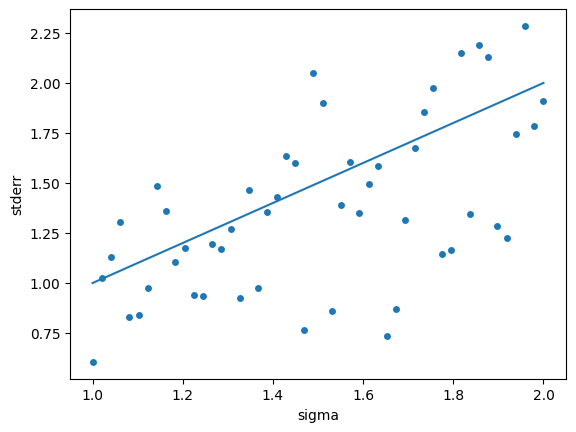

In [34]:
from matplotlib import pyplot as plt

ds.sigma.plot()
ds.stderr.plot.scatter()
plt.show()